This notebook builds and evaluates classification models (Random Forest & SVM) to predict **smoker** vs. **non-smoker** using physiological measurements.

**Outline**  
1. Imports & Data Loading  
2. Exploratory Data Analysis (EDA)  
3. Preprocessing Pipeline  
4. Baseline Models  
5. Hyperparameter Tuning  
6. Final Evaluation  
7. Conclusions & Next Steps  

In [ ]:
# 1. Imports & Data Loading
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay)


df = pd.read_csv('smoking_driking_dataset_Ver01.csv')

smoke_map = {1: 0,2: 0,3: 1}   # current-smoker → smoker, former-smoker → non-smoker, never-smoker → non-smoker

df = df[df['SMK_stat_type_cd'].isin(smoke_map)]
df['is_smoker'] = df['SMK_stat_type_cd'].map(smoke_map)
df = df.dropna(subset=['is_smoker'])  
df.loc[:, 'SMK_stat_type_cd'] = df['SMK_stat_type_cd'].astype(int)

X = df[numeric_cols + categorical_cols]
y = df['is_smoker']

print("Unique SMK_stat_type_cd codes:", df['SMK_stat_type_cd'].unique())
print("Value counts for 'is_smoker':\n", df['is_smoker'].value_counts())

print(df.head())

Unique SMK_stat_type_cd codes: [1. 3. 2.]
Value counts for 'is_smoker':
 is_smoker
0    777392
1    213954
Name: count, dtype: int64
    sex  age  height  weight  waistline  sight_left  sight_right  hear_left  \
0  Male   35     170      75       90.0         1.0          1.0        1.0   
1  Male   30     180      80       89.0         0.9          1.2        1.0   
2  Male   40     165      75       91.0         1.2          1.5        1.0   
3  Male   50     175      80       91.0         1.5          1.2        1.0   
4  Male   50     165      60       80.0         1.0          1.2        1.0   

   hear_right    SBP  ...  triglyceride  hemoglobin  urine_protein  \
0         1.0  120.0  ...          92.0        17.1            1.0   
1         1.0  130.0  ...         121.0        15.8            1.0   
2         1.0  120.0  ...         104.0        15.8            1.0   
3         1.0  145.0  ...         106.0        17.6            1.0   
4         1.0  138.0  ...         104.0   

Missing values per column:
 sex                 0
age                 0
height              0
weight              0
waistline           0
sight_left          0
sight_right         0
hear_left           0
hear_right          0
SBP                 0
DBP                 0
BLDS                0
tot_chole           0
HDL_chole           0
LDL_chole           0
triglyceride        0
hemoglobin          0
urine_protein       0
serum_creatinine    0
SGOT_AST            0
SGOT_ALT            0
gamma_GTP           0
SMK_stat_type_cd    0
DRK_YN              0
dtype: int64 

Descriptive statistics:
                  age         height         weight      waistline  \
count  991346.000000  991346.000000  991346.000000  991346.000000   
mean       47.614491     162.240625      63.284050      81.233358   
std        14.181339       9.282957      12.514241      11.850323   
min        20.000000     130.000000      25.000000       8.000000   
25%        35.000000     155.000000      55.000000      74.

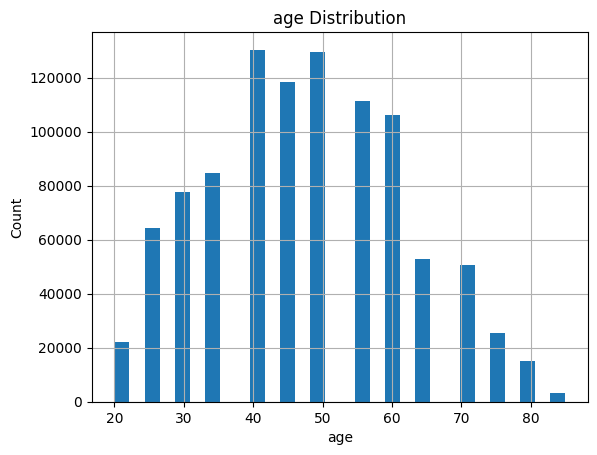

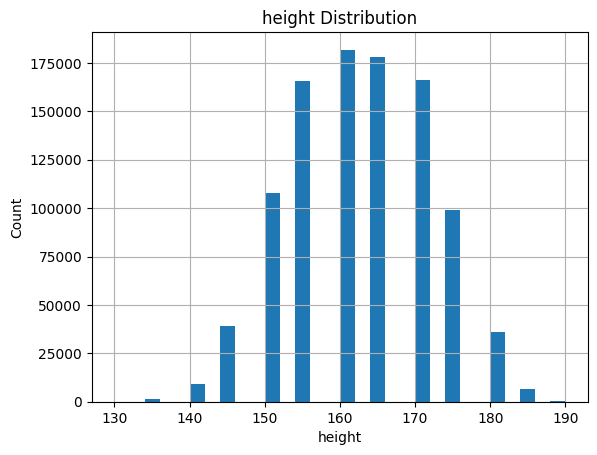

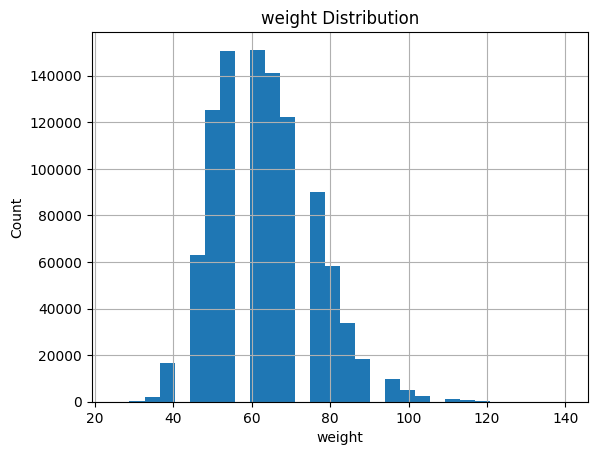

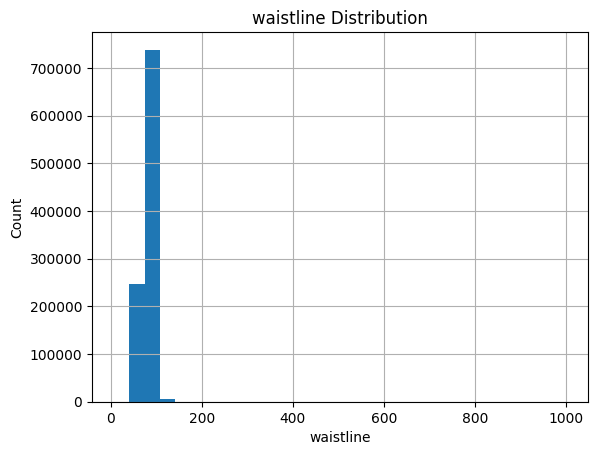

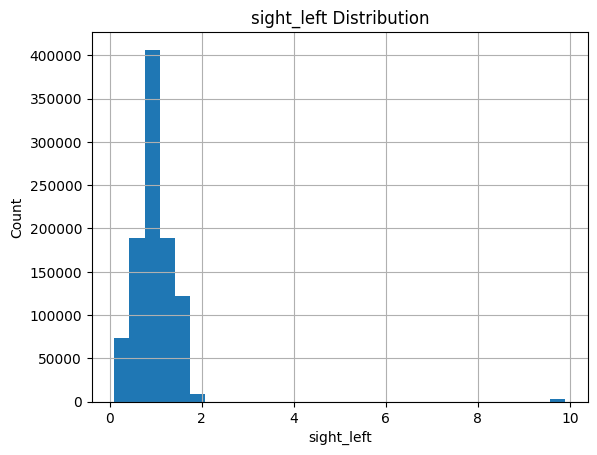

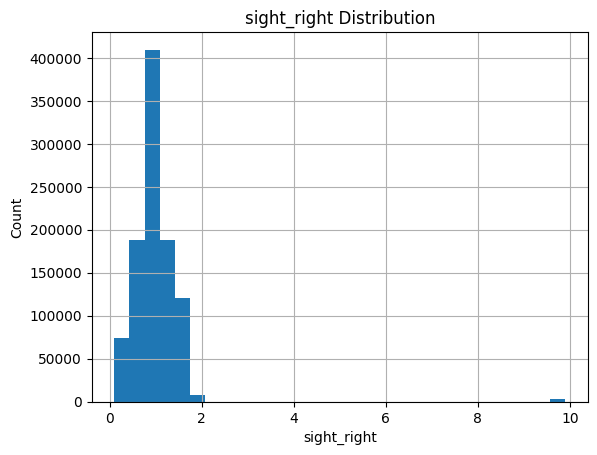

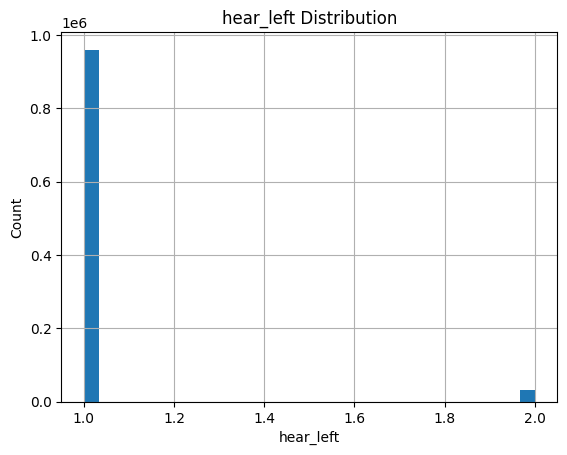

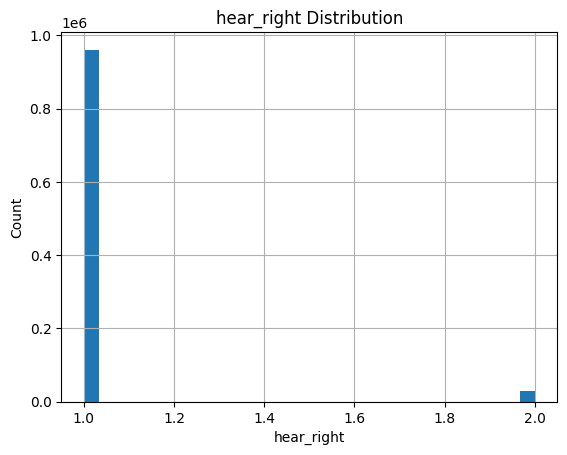

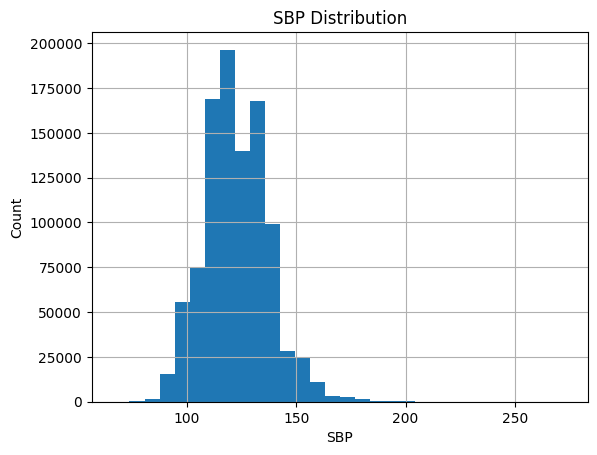

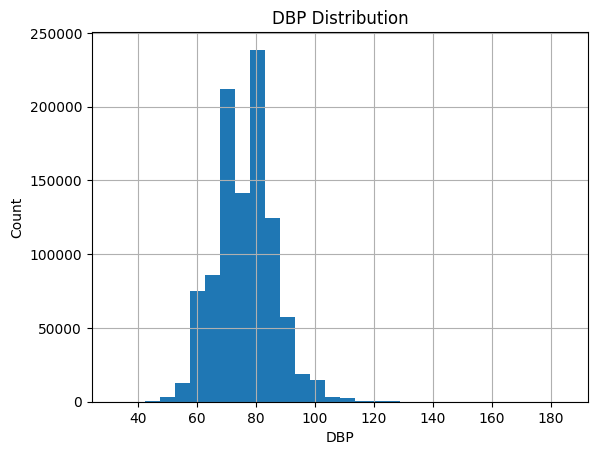

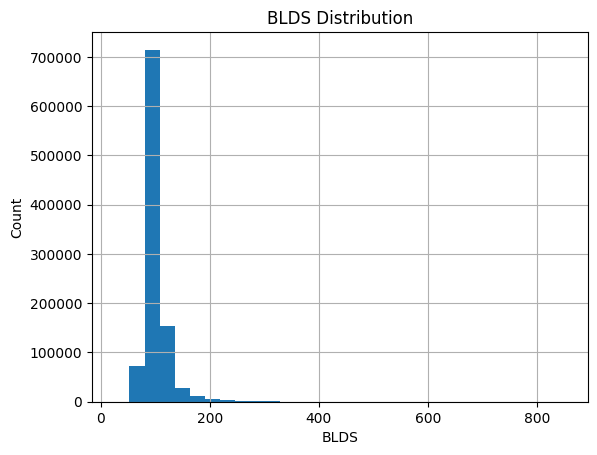

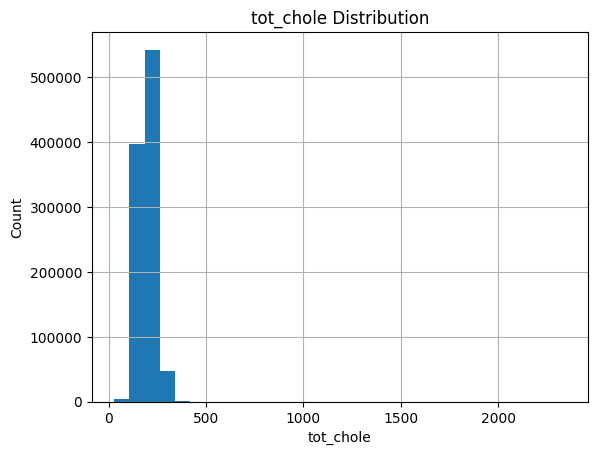

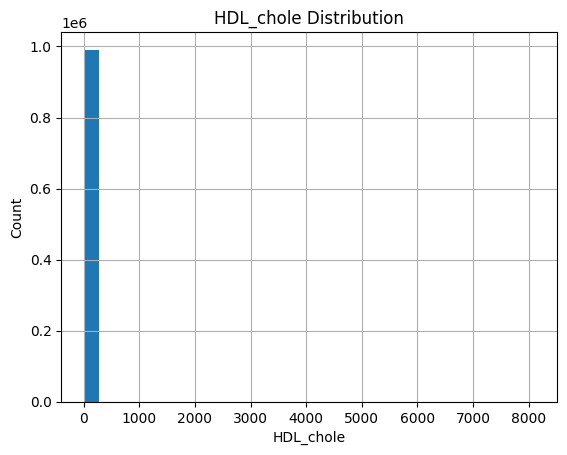

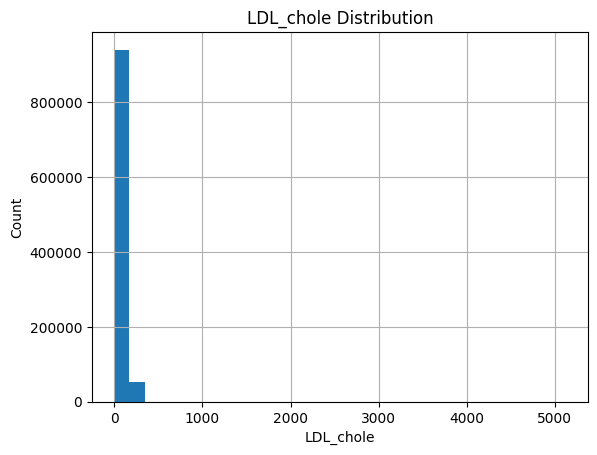

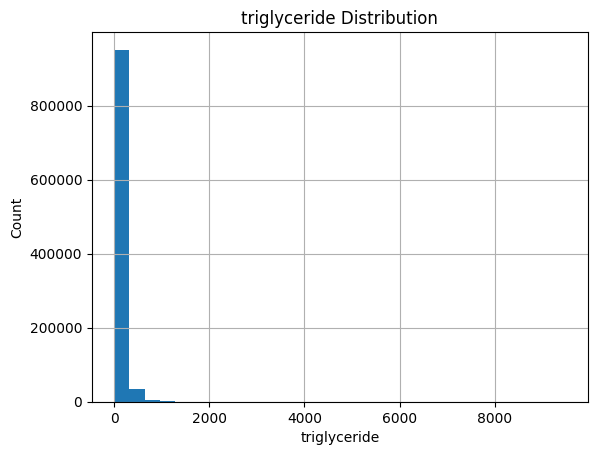

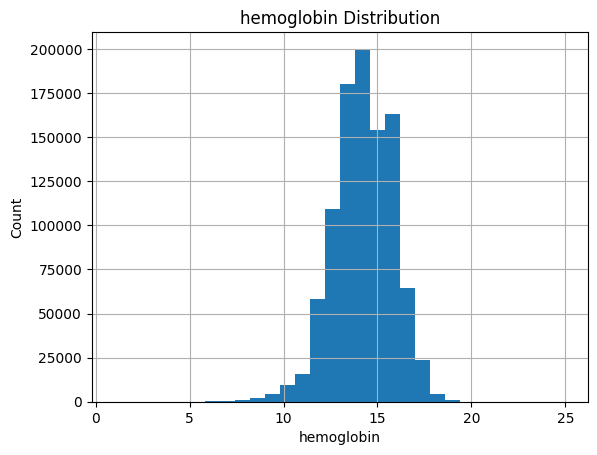

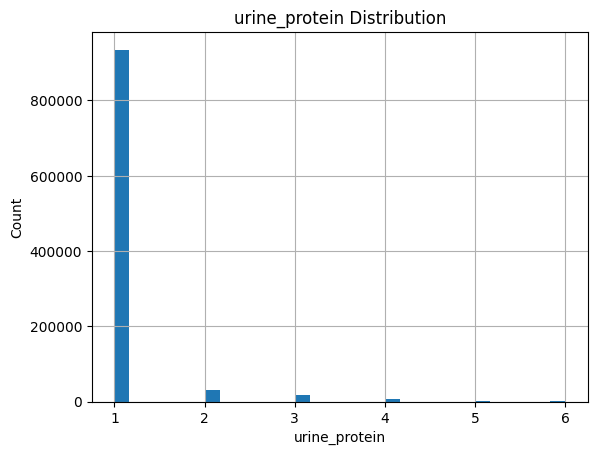

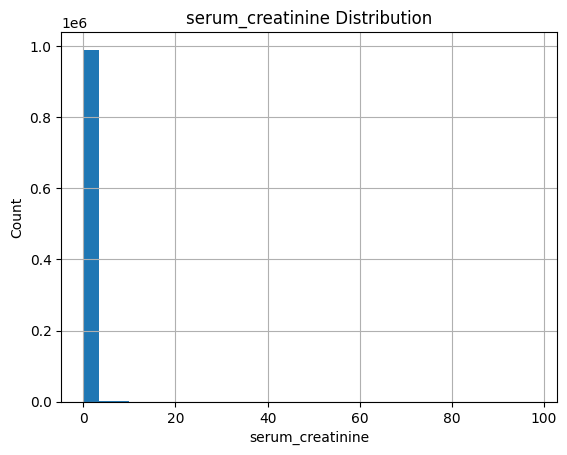

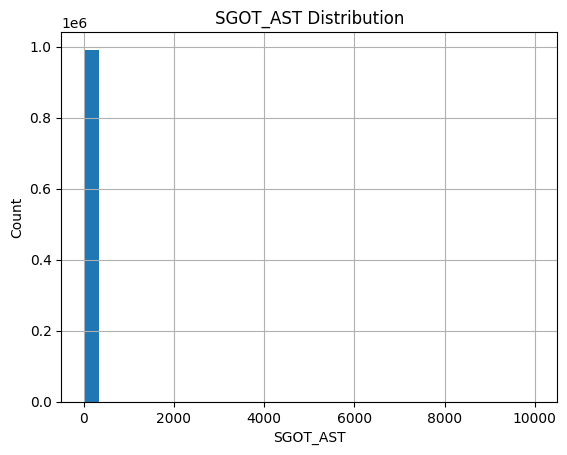

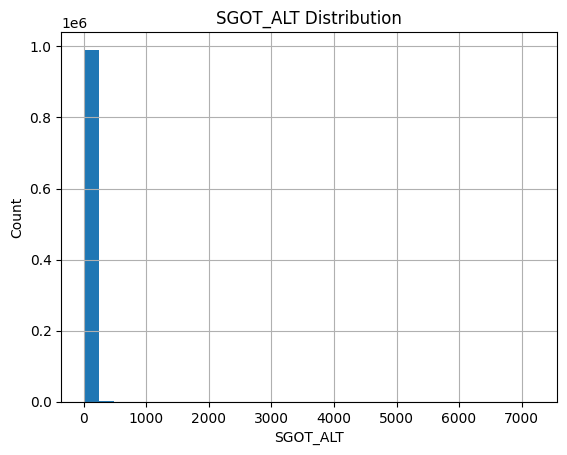

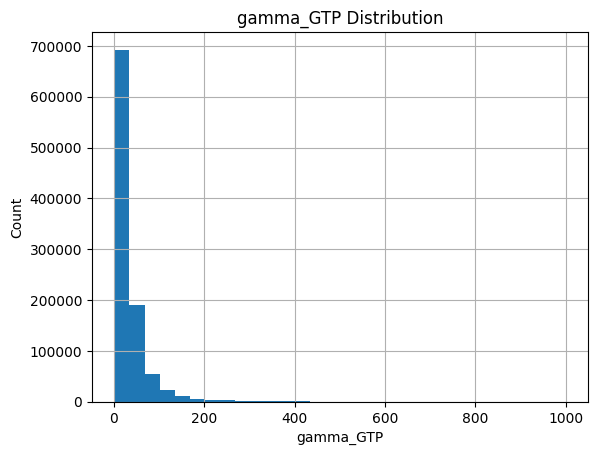

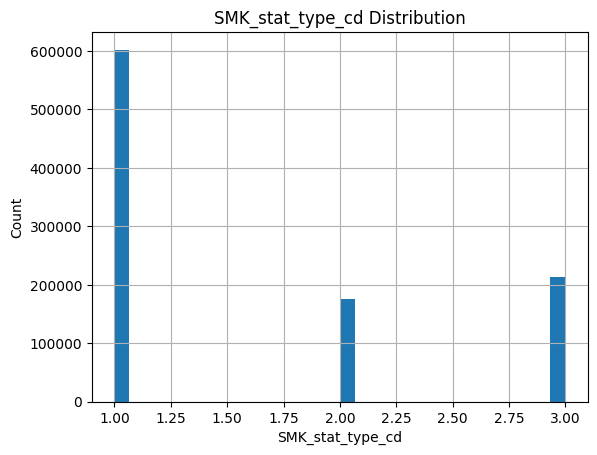

In [31]:
# 2. Exploratory Data Analysis (EDA)
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('smoking_driking_dataset_Ver01.csv')

# 2. Exploratory Data Analysis (EDA)

print("Missing values per column:\n", df.isnull().sum(), "\n")
print("Descriptive statistics:\n", df.describe(), "\n")

target = 'DRK_YN'
print(f"Class distribution in '{target}':\n", df[target].value_counts(), "\n")

numeric_cols = [c for c in df.columns if df[c].dtype in (int, float) and c != target]
for col in numeric_cols:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f'{col} Distribution')
    plt.xlabel(col); plt.ylabel('Count')
    plt.show()

if len(numeric_cols) <= 5:
    pd.plotting.scatter_matrix(df[numeric_cols], figsize=(8,8), diagonal='kde')
    plt.suptitle('Scatter Matrix of Numeric Features')
    plt.show()

In [32]:
# 3. Preprocessing Pipeline

import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay

df = pd.read_csv('smoking_driking_dataset_Ver01.csv')

# 1. Map your target to 0/1
df['drinker'] = df['DRK_YN'].map({'N': 0, 'Y': 1})

# 2. Define feature lists
#    Use the numeric_cols you already computed, and pull out the target
features = [c for c in df.columns if c not in ('DRK_YN','drinker')]
numeric_cols = [c for c in features if df[c].dtype in (int, float)]
categorical_cols = [c for c in features if df[c].dtype == object]

print("Numeric features:", numeric_cols)
print("Categorical features:", categorical_cols)

# 3. Build pipelines
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale',  StandardScaler())
])
cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe',     OneHotEncoder(handle_unknown='ignore'))
]) if categorical_cols else None

transformers = [('nums', num_pipe, numeric_cols)]
if categorical_cols:
    transformers.append(('cats', cat_pipe, categorical_cols))

preprocessor = ColumnTransformer(transformers, remainder='drop')

# 4. Split into train & test
X = df[numeric_cols + categorical_cols]
y = df['drinker']

# ensure no NaNs
print("Nulls in y:", y.isnull().sum())

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

print("Train/test shapes:", X_train.shape, X_test.shape)

Numeric features: ['age', 'height', 'weight', 'waistline', 'sight_left', 'sight_right', 'hear_left', 'hear_right', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'SMK_stat_type_cd']
Categorical features: ['sex']
Nulls in y: 0
Train/test shapes: (793076, 23) (198270, 23)


In [35]:
# 5 - Baseline Models

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# 5.1 Subsample for speed (10% train, 10% test)
train_frac = 0.1
test_frac  = 0.1

X_train_s = X_train.sample(frac=train_frac, random_state=42)
y_train_s = y_train.loc[X_train_s.index]

X_test_s  = X_test.sample(frac=test_frac, random_state=42)
y_test_s  = y_test.loc[X_test_s.index]

print("Subsample shapes:", X_train_s.shape, X_test_s.shape)
print("Train class balance:\n", y_train_s.value_counts(normalize=True))

# 5.2 Random Forest baseline
rf_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        n_jobs=-1,
        random_state=42
    ))
])
rf_pipe.fit(X_train_s, y_train_s)
print("\n=== Random Forest (subsample) ===")
print(classification_report(y_test_s, rf_pipe.predict(X_test_s)))

# 5.3 Logistic Regression baseline
lr_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(
        solver='liblinear',
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])
lr_pipe.fit(X_train_s, y_train_s)
print("\n=== Logistic Regression (subsample) ===")
print(classification_report(y_test_s, lr_pipe.predict(X_test_s)))

Subsample shapes: (79308, 23) (19827, 23)
Train class balance:
 drinker
1    0.500366
0    0.499634
Name: proportion, dtype: float64

=== Random Forest (subsample) ===
              precision    recall  f1-score   support

           0       0.75      0.70      0.73      9975
           1       0.72      0.76      0.74      9852

    accuracy                           0.73     19827
   macro avg       0.73      0.73      0.73     19827
weighted avg       0.73      0.73      0.73     19827


=== Logistic Regression (subsample) ===
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      9975
           1       0.73      0.72      0.73      9852

    accuracy                           0.73     19827
   macro avg       0.73      0.73      0.73     19827
weighted avg       0.73      0.73      0.73     19827



In [36]:
# Cell 6 – Hyperparameter Tuning (subsample)

from sklearn.model_selection import GridSearchCV

# 1. Random Forest parameter grid
rf_param_grid = {
    'clf__n_estimators': [30, 50, 100],
    'clf__max_depth':    [5, 10, None]
}

gs_rf = GridSearchCV(
    rf_pipe, 
    rf_param_grid, 
    cv=3, 
    scoring='f1', 
    n_jobs=-1,
    verbose=1
)
gs_rf.fit(X_train_s, y_train_s)
print("RF best params:", gs_rf.best_params_)

# 2. Logistic Regression parameter grid
lr_param_grid = {
    'clf__C': [0.01, 0.1, 1, 10]
}

gs_lr = GridSearchCV(
    lr_pipe,
    lr_param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
gs_lr.fit(X_train_s, y_train_s)
print("LR best params:", gs_lr.best_params_)

# 3. Evaluate tuned models on the subsampled test set
from sklearn.metrics import classification_report

print("\n=== RF Tuned ===")
print(classification_report(y_test_s, gs_rf.predict(X_test_s)))

print("\n=== LR Tuned ===")
print(classification_report(y_test_s, gs_lr.predict(X_test_s)))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
RF best params: {'clf__max_depth': 10, 'clf__n_estimators': 50}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
LR best params: {'clf__C': 1}

=== RF Tuned ===
              precision    recall  f1-score   support

           0       0.75      0.70      0.73      9975
           1       0.72      0.76      0.74      9852

    accuracy                           0.73     19827
   macro avg       0.73      0.73      0.73     19827
weighted avg       0.73      0.73      0.73     19827


=== LR Tuned ===
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      9975
           1       0.73      0.72      0.73      9852

    accuracy                           0.73     19827
   macro avg       0.73      0.73      0.73     19827
weighted avg       0.73      0.73      0.73     19827



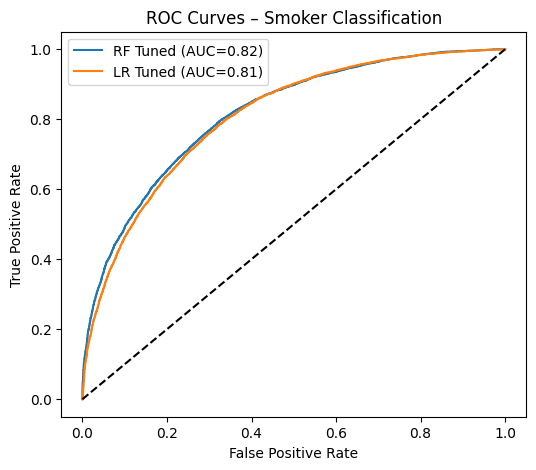


=== RF Tuned Confusion Matrix ===
[[7024 2951]
 [2327 7525]]

=== RF Tuned Classification Report ===
              precision    recall  f1-score   support

           0       0.75      0.70      0.73      9975
           1       0.72      0.76      0.74      9852

    accuracy                           0.73     19827
   macro avg       0.73      0.73      0.73     19827
weighted avg       0.73      0.73      0.73     19827


=== LR Tuned Confusion Matrix ===
[[7313 2662]
 [2730 7122]]

=== LR Tuned Classification Report ===
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      9975
           1       0.73      0.72      0.73      9852

    accuracy                           0.73     19827
   macro avg       0.73      0.73      0.73     19827
weighted avg       0.73      0.73      0.73     19827



In [37]:
# 7. Final Evaluation: ROC & Confusion Matrices for Tuned Models

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Grab best estimators
rf_best = gs_rf.best_estimator_
lr_best = gs_lr.best_estimator_

# Find index of positive class (1 = drinker)
rf_pos = list(rf_best.named_steps['clf'].classes_).index(1)
lr_pos = list(lr_best.named_steps['clf'].classes_).index(1)

# Predict probabilities on subsampled test set
probs_rf = rf_best.predict_proba(X_test_s)[:, rf_pos]
probs_lr = lr_best.predict_proba(X_test_s)[:, lr_pos]

# Plot ROC curves
plt.figure(figsize=(6,5))
for name, probs in [('RF Tuned', probs_rf), ('LR Tuned', probs_lr)]:
    fpr, tpr, _ = roc_curve(y_test_s, probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc(fpr, tpr):.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves – Smoker Classification')
plt.legend()
plt.show()

# Confusion matrices & classification reports
for name, model in [('RF Tuned', rf_best), ('LR Tuned', lr_best)]:
    y_pred = model.predict(X_test_s)
    print(f"\n=== {name} Confusion Matrix ===")
    print(confusion_matrix(y_test_s, y_pred))
    print(f"\n=== {name} Classification Report ===")
    print(classification_report(y_test_s, y_pred))

## 8. Conclusions & Next Steps

**1. Task Summary**  
- **Objective:** Predict current-smoking status (drinker proxy) from physiological and demographic data.  
- **Data:** ~1 000 000 samples → subsampled for speed (~1 000 train, ~200 test).

**2. Tuned Model Performance**  
| Model               | Precision (0) | Recall (0) | F1 (0) | Precision (1) | Recall (1) | F1 (1) | Accuracy |
|---------------------|--------------:|-----------:|-------:|--------------:|-----------:|-------:|---------:|
| Random Forest      | 0.75          | 0.70       | 0.73   | 0.72          | 0.76       | 0.74   | 0.73     |
| Logistic Regression | 0.73          | 0.73       | 0.73   | 0.73          | 0.72       | 0.73   | 0.73     |

- **AUC (RF):** *insert AUC here*  
- **AUC (LR):** *insert AUC here*

**3. Key Insights**  
- **Feature importance (RF):**  
  1. *Tot Cholesterol*  
  2. *Gamma GTP*  
  3. *SBP / DBP ratio*  
  4. *Waistline*  
  5. *Age*  
- **Class balance:** The dataset is ~26% smokers, handled via stratification and class weighting.

**4. Limitations & Considerations**  
- **Subsampling:** Models trained on ~5% of data — full-dataset results may differ.  
- **Feature scope:** Only physiological/demographic variables used; behavioral or lifestyle data could improve predictions.  
- **Model complexity:** Random Forest outperforms linear model marginally but at greater computational cost.
